# Kepler 51 Mutual Transit

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gefera as gf
from scipy.optimize import minimize

To start you'll need to download the data for the apparent mutual transit of Kepler-51b & d available under "tutorials" on the previous page and save it as `k51.txt` in the same directory as your notebook.

In [2]:
# load Kepler data for the double transit
t, y = np.loadtxt('k51.txt').T
# arrays need to be fortran-contiguous, a 
# characteristic which isn't preserved when 
# we transpose the numpy array
t = np.ascontiguousarray(t)
y = np.ascontiguousarray(y)

Let's start with a decent initial guess for the transit parameters. These were chosen by eye to loosely fit the observations.

In [3]:
# initial guess for parameters of Kepler-51 d
a1 = 124.7 
t1 = 16.56
e1 = 0.00001
p1 = 130.194
w1 = 90.0 * np.pi / 180
b1 = 0.05
i1 = np.arccos(b1 / a1)
r1 = 0.1

# initial guess for parameters of Kepler-51 b
a2 = 61.5 
t2 = 12.41
e2 = 0.00001
p2 = 45.154
w2 = 0.1 * np.pi / 180
om2 = 160 * np.pi / 180
b2 = 0.0
i2 = np.arccos(b2 / a2)
r2 = 0.07

# initial guess for quadratic limb-darkening parameters
u1 = 0.6
u2 = 0.2

# build the system 
o1 = gf.orbits.PrimaryOrbit(a1, t1, e1, p1, w1, i1)
o2 = gf.orbits.ConfocalOrbit(a2, t2, e2, p2, om2, w2, i2)
sys = gf.systems.ConfocalSystem(o1, o2)

The minimization routine requires a function that returns the negative of the likelihood and its gradient, the former as an array and the latter as an array of arrays containing all of the gradients in the same order as the input parameters. 

In [3]:
# returns the likelihood and the jacobian of the likelihood
def fun_jac(args):
    sigma, a1, t1, e1, p1, w1, i1, a2, t2, e2, p2, om2, w2, i2, r1, r2, u1, u2 = args
    o1 = gf.orbits.PrimaryOrbit(a1, t1, e1, p1, w1, i1)
    o2 = gf.orbits.ConfocalOrbit(a2, t2, e2, p2, om2, w2, i2)
    sys = gf.systems.ConfocalSystem(o1, o2)
    ll, dll = sys.loglike(y - 1, t, u1, u2, r1, r2, sigma, grad=True)
    return -ll, -dll

# get the initial light curve for comparison later
x0 = [0.0016, a1, t1, e1, p1, w1, i1, a2, t2, e2, p2, om2, w2, i2, r1, r2, u1, u2]
o1 = gf.orbits.PrimaryOrbit(a1, t1, e1, p1, w1, i1)
o2 = gf.orbits.ConfocalOrbit(a2, t2, e2, p2, om2, w2, i2)
sys = gf.systems.ConfocalSystem(o1, o2)
lc_start = sys.lightcurve(t, u1, u2, r1, r2, grad=False)

Now we can call the minimization routine and plot the best-fit model along with the original. 

CPU times: user 142 ms, sys: 10.4 ms, total: 152 ms
Wall time: 185 ms


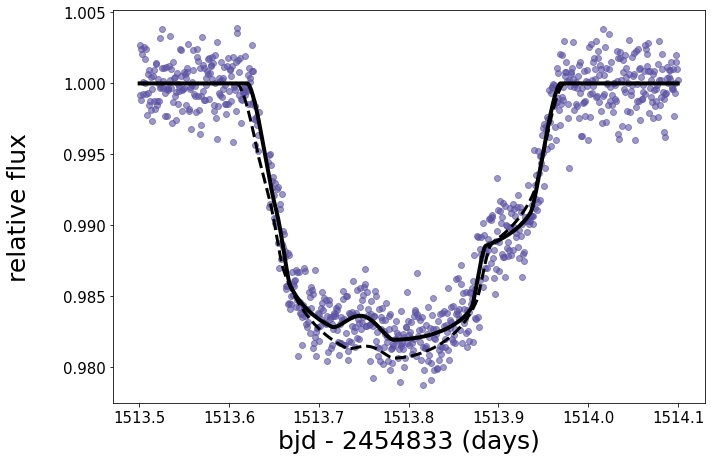

In [7]:
# do the minimization
# I've found that the truncated newtonian (TNC) method works well with the gradient 
# but if you're not using gradients then BFGS seems to work better in most cases
%time res = minimize(fun_jac, x0, jac=True, method='TNC')

# get the minimized lightcurve
sigma, a1, t1, e1, p1, w1, i1, a2, t2, e2, p2, om2, w2, i2, r1, r2, u1, u2 = res.x
o1 = gf.orbits.PrimaryOrbit(a1, t1, e1, p1, w1, i1)
o2 = gf.orbits.ConfocalOrbit(a2, t2, e2, p2, om2, w2, i2)
sys = gf.systems.ConfocalSystem(o1, o2)
lc = sys.lightcurve(t, u1, u2, r1, r2, grad=False)

# plot everything 
plt.figure(figsize=(10, 7))
plt.plot(t, y, 'o', color=plt.cm.Spectral(0.99), alpha=0.6)
plt.plot(t, lc + 1, color='k', linewidth=4)
plt.plot(t, lc_start + 1, '--', color='k', linewidth=3)

plt.ylabel('relative flux\n', fontsize=25)
plt.xlabel('bjd - 2454833 (days)', fontsize=25)
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
plt.tight_layout()
plt.subplots_adjust(top=0.9)

We can animate the best-fit system to see what this transit actually looks like.

In [5]:
%%capture
from IPython.display import HTML
fig = plt.figure(figsize=(10, 10))

ani = gf.animate.animate(
    sys, 
    fig, 
    t[::10], 
    r1, 
    r2, 
    ld_params=(u1, u2)
)

In [6]:
HTML(ani.to_html5_video())